In [1]:
import sys
import time

import numpy as np
import tensorflow as tf

sys.path.append('../../')

from src.dnnseparate.L41model import L41Model

from src.utils.clustering_utils import clustering_separate, get_cluster_masks, process_signal

from src.features.mixer import FeatureMixer
from src.features.supervised_iterator import SupervisedIterator, SupervisedMixer
from src.features.hdf5_iterator import SplitsIterator
from src.features.spectral_features import istft
from src.features.data_preprocessing import undo_preemphasis
from src.utils.bss_eval import bss_eval_sources

import IPython
from IPython.display import Audio
from matplotlib import pyplot as plt
fig_size = [0,0]
fig_size[0] = 8
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

### Set up data I/O

In [2]:
fft_size = 512

numsources = 2
batchsize = 256
datashape = (40, 257)
embedding_size = 600
libridev='/local_data/teams/magnolia/librispeech/processed_dev_clean.h5'
libritrain='/local_data/teams/magnolia/librispeech/processed_train-clean-100.h5'
# libritest='Data/librispeech/processed_test_clean.h5'

with open('../../data/librispeech/authors/train-clean-100-F.txt','r') as speakers:
    speaker_keys = speakers.read().splitlines()
    in_set_F = speakers.read().splitlines()
    
with open('../../data/librispeech/authors/train-clean-100-M.txt','r') as speakers:
    speaker_keys += speakers.read().splitlines()
    in_set_M = speakers.read().splitlines()

### Make a mixer

In [3]:
siterator = SplitsIterator([0.8,0.1,0.1], libritrain, speaker_keys=speaker_keys, shape=datashape, return_key=True)
siterator.set_split(0)

mixer = SupervisedMixer([siterator,siterator], shape=datashape, 
                        mix_method='add', diffseed=True)

tbeg = time.clock()
X, Y, I = mixer.get_batch(batchsize, out_TF=None)
Y = Y.reshape(batchsize,2,datashape[0],datashape[1])
Y = Y.transpose([0,2,3,1])
tend = time.clock()
print('Supervised feature mixer with 3 libridev sources timed at ', (tend-tbeg), 'sec')

Supervised feature mixer with 3 libridev sources timed at  1.3243710000000002 sec


### Generate some validation data

In [4]:
siterator.set_split(1)
Xdv, Ydv, Idv = mixer.get_batch(batchsize, out_TF=None)
Ydv = Ydv.reshape(batchsize,2,datashape[0],datashape[1])
Ydv = Ydv.transpose(0,2,3,1)
Xinv = np.sqrt(Xdv)
Xinv = (Xinv - Xinv.min())/(Xinv.max() - Xinv.min())
siterator.set_split(0)

### Create an instance of Lab41's model

In [5]:
model = L41Model(nonlinearity='tanh')
model.initialize()

iterations = []
costs = []

t_costs = []
v_costs = []
modeltimer = []

last_saved = 0

In [6]:
# model.load('models/magnolia/lab41_model.ckpt')

### Training loop

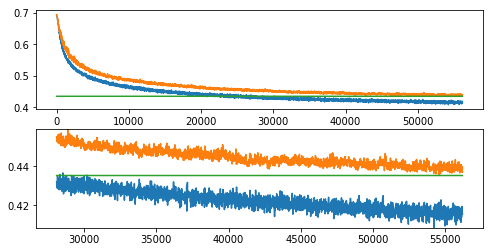

Cost on batch 56180 is 0.437285
Last saved 1620 iterations ago.


In [ ]:
try:
    start = iterations[-1]
except:
    start = 0

    
siterator.set_split(0)
for i in range(2000000):
    
    Xdata, Ydata, Idata = mixer.get_batch(batchsize, out_TF=None)
    Ydata = Ydata.reshape(batchsize,2,datashape[0],datashape[1])
    Ydata = Ydata.transpose(0,2,3,1)
    
    Xin = np.sqrt(np.abs(Xdata))
    Xin = (Xin - Xin.min())/(Xin.max() - Xin.min())
    
    tbegin = time.clock()
    c = model.train_on_batch(Xin,Ydata,Idata)
    modeltimer += [ time.clock()-tbegin ]

    costs.append(c)
    
    if (i+1) % 10 == 0:
        IPython.display.clear_output(wait=True)
        c_v = model.get_cost(Xinv, Ydv, Idv)
        
        try:
            if c_v < min(v_costs) and len(iterations) > 0:
                print("Saving the model because c_v is", min(v_costs) - c_v, "below the old min.")
                model.save('lab41_model-x.ckpt')
                last_saved = iterations[-1]
        except:
            pass
        
        t_costs.append(np.mean(costs))
        v_costs.append(c_v)
        
        iterations.append(i + 1 + start)
        
        length = len(iterations)
        cutoff = int(0.5*length)
        lowline = [min(v_costs)]*len(iterations)
        
        f, (ax1, ax2) = plt.subplots(2,1)
        
        ax1.plot(iterations,t_costs)
        ax1.plot(iterations,v_costs)
        ax1.plot(iterations,lowline)
        
        y_u = max(max(t_costs[cutoff:]),max(v_costs[cutoff:]))
        y_l = min(min(t_costs[cutoff:]),min(v_costs[cutoff:]))
        
        ax2.set_ylim(y_l,y_u)
        
        ax2.plot(iterations[cutoff:], t_costs[cutoff:])
        ax2.plot(iterations[cutoff:], v_costs[cutoff:])
        ax2.plot(iterations[cutoff:], lowline[cutoff:])
        plt.show()
        
        print("Cost on batch", iterations[-1], "is", c_v)
        print("Last saved",iterations[-1]-last_saved,"iterations ago.")
        costs = []
        
        if iterations[-1]-last_saved > 100000:
            print("Done!")
            break

### Generate a sample and listen to the results on it

In [60]:
libridev='/local_data/teams/magnolia/librispeech/processed_dev-clean.h5'
sample_rate = 1e4
overlap = 0.0256
long_mixer = FeatureMixer([libridev,libridev], shape=(200,None)) 

In [81]:
data = next(long_mixer)
spec = data[0]
signal = istft(spec,sample_rate,None,overlap,two_sided=False,fft_size=512)
signal = undo_preemphasis(signal)

Audio(signal,rate=sample_rate)

In [82]:
sources = clustering_separate(signal,sample_rate,model,2)

In [83]:
Audio(sources[0], rate=sample_rate)

In [84]:
Audio(sources[1], rate=sample_rate)

In [ ]:
spectrogram, vectors = process_signal(signal,sample_rate,model)

In [ ]:
plt.matshow(np.sqrt(np.abs(spectrogram)))
plt.show()

In [ ]:
masks = get_cluster_masks(vectors,2)
plt.matshow(masks[:,:,0].T, origin='lower', cmap='bone')
plt.show()

### Check the affinity matrix

In [ ]:
Xdata, Ydata, Idata = mixer.get_batch(1, out_TF=None)
Ydata = Ydata.reshape(1,2,datashape[0],datashape[1])
Ydata = Ydata.transpose(0,2,3,1)

Xin = np.sqrt(np.abs(Xdata))
Xin = (Xin - Xin.min())/(Xin.max() - Xin.min())

vectors = model.get_vectors(Xin)
A = vectors[0].reshape(40*257,40)@vectors[0].reshape(40*257,40).T

resa = ((1+Ydata[0])/2).reshape((40*257,2))
B =  resa @ resa.T

In [ ]:
plt.matshow(A[0:5000,0:5000],vmin=0,vmax=1)
plt.show()

In [ ]:
plt.matshow(B[0:5000,0:5000])
plt.show()

In [ ]:
def invert_spectrogram(magnitude,phase):
    return istft(np.square(magnitude)*np.exp(phase*1.0j),sample_rate,None,overlap,two_sided=False,fft_size=fft_size)

def bss_eval_sample(mixer, num_sources):
    data = next(mixer)
    
    mixes = [invert_spectrogram(np.abs(data[0]),np.unwrap(np.angle(data[0]))) for i in range(1,num_sources + 1)]
    sources = [invert_spectrogram(np.abs(data[i][1]),np.unwrap(np.angle(data[i][1]))) for i in range(1,num_sources + 1)]
    
    mixes = [undo_preemphasis(mix) for mix in mixes]
    sources = [undo_preemphasis(source) for source in sources]
    
    input_mix = np.stack(mixes)
    reference_sources = np.stack(sources)
    estimated_sources = clustering_separate(mixes[0],1e4,model,num_sources)
    
    do_nothing = bss_eval_sources(reference_sources, input_mix)
    do_something = bss_eval_sources(reference_sources, estimated_sources)
    
    sdr = do_something[0] - do_nothing[0]
    sir = do_something[1] - do_nothing[1]
    sar = do_something[2] - do_nothing[2]
    
    return {'SDR': sdr, 'SIR': sir, 'SAR': sar}

def bss_eval(mixer, num_sources, num_samples):
    SDR = np.zeros(num_samples)
    SIR = np.zeros(num_samples)
    SAR = np.zeros(num_samples)
    
    for i in range(num_samples):
        evals = bss_eval_sample(mixer, 2)
        SDR[i] = 1/(2)*(evals['SDR'][0] + evals['SDR'][1])
        SIR[i] = 1/(2)*(evals['SIR'][0] + evals['SIR'][1])
        SAR[i] = 1/(2)*(evals['SAR'][0] + evals['SAR'][1])
    
    return SDR, SIR, SAR

### Evaluate BSS metrics on the inset all subset

In [ ]:
siterator.set_split(2)

samples = 500
SDR,SIR,SAR = bss_eval(mixer, 2, samples)

print(np.mean(SDR))
print(np.std(SDR)/np.sqrt(samples))

### Evaluate BSS metrics on the FF inset subset

In [ ]:
siterator.set_split(2)
siterator.speaker_subset(in_set_F)

samples = 500
SDR,SIR,SAR = bss_eval(mixer, 2, samples)

print(np.mean(SDR))
print(np.std(SDR)/np.sqrt(samples))

### Evaluate BSS metrics on the MM inset subset

In [ ]:
siterator.set_split(2)
siterator.speaker_subset(in_set_M)

samples = 500
SDR,SIR,SAR = bss_eval(mixer, 2, samples)

print(np.mean(SDR))
print(np.std(SDR)/np.sqrt(samples))

### Evaluate BSS metrics on the FM inset subset

In [ ]:
siterator2 = SplitsIterator([0.8,0.1,0.1], libritrain, speaker_keys=speaker_keys, shape=datashape, return_key=True)

siterator.set_split(2)
siterator2.set_split(2)

siterator.speaker_subset(in_set_F)
siterator2.speaker_subset(in_set_M)

FMmixer = SupervisedMixer([siterator,siterator2], shape=datashape, 
                        mix_method='add', diffseed=True)

samples = 500
SDR,SIR,SAR = bss_eval(FMmixer, 2, samples)

print(np.mean(SDR))
print(np.std(SDR)/np.sqrt(samples))

### Create mixers for out of set FF FM MM, all, speaker mixes

In [ ]:
with open('Magnolia/data/librispeech/authors/test-clean-F.txt','r') as speakers:
    out_set_F = speakers.read().splitlines()

with open('Magnolia/data/librispeech/authors/test-clean-M.txt','r') as speakers:
    out_set_M = speakers.read().splitlines()

all_speakers = out_set_F + out_set_M

Fiterator = SplitsIterator([1], libritest, speaker_keys=out_set_F, shape=datashape, return_key=True)
Fiterator.set_split(0)
Miterator = SplitsIterator([1], libritest, speaker_keys=out_set_M, shape=datashape, return_key=True)
Miterator.set_split(0)
Aiterator = SplitsIterator([1], libritest, speaker_keys=all_speakers, shape=datashape, return_key=True)

outsetFFmixer = SupervisedMixer([Fiterator,Fiterator], shape=datashape, 
                        mix_method='add', diffseed=True)
outsetFMmixer = SupervisedMixer([Fiterator,Miterator], shape=datashape, 
                        mix_method='add', diffseed=True)
outsetMMmixer = SupervisedMixer([Miterator,Miterator], shape=datashape, 
                        mix_method='add', diffseed=True)
outsetAAmixer = SupervisedMixer([Aiterator,Aiterator], shape=datashape, 
                        mix_method='add', diffseed=True)

In [ ]:
samples = 500
SDR,SIR,SAR = bss_eval(outsetFFmixer, 2, samples)

print(np.mean(SDR))
print(np.std(SDR)/np.sqrt(samples))

In [ ]:
samples = 500
SDR,SIR,SAR = bss_eval(outsetFMmixer, 2, samples)

print(np.mean(SDR))
print(np.std(SDR)/np.sqrt(samples))

In [ ]:
samples = 500
SDR,SIR,SAR = bss_eval(outsetMMmixer, 2, samples)

print(np.mean(SDR))
print(np.std(SDR)/np.sqrt(samples))

In [ ]:
samples = 500
SDR,SIR,SAR = bss_eval(outsetAAmixer, 2, samples)

print(np.mean(SDR))
print(np.std(SDR)/np.sqrt(samples))